In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config

set_config(transform_output="pandas")

df = sns.load_dataset("iris")

X = df.drop(columns="species")
y = df.species

In [2]:
X.dtypes

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
dtype: object

In [3]:
y.dtypes

dtype('O')

In [4]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [5]:
from sklearn.neighbors import KNeighborsClassifier


def knn_clf(X, y, k=5):
    knn = KNeighborsClassifier(
        n_neighbors=k, metric="euclidean", n_jobs=-1
    )
    ## Notar que es posible utilizar Variables categóricas como Etiquetas...
    knn.fit(X, y)
    y_pred = knn.predict(X)
    print(f"Puntaje k = {k}: {knn.score(X,y)}")
    return y_pred


y_pred = knn_clf(X, y, k=5)

Puntaje k = 5: 0.9666666666666667


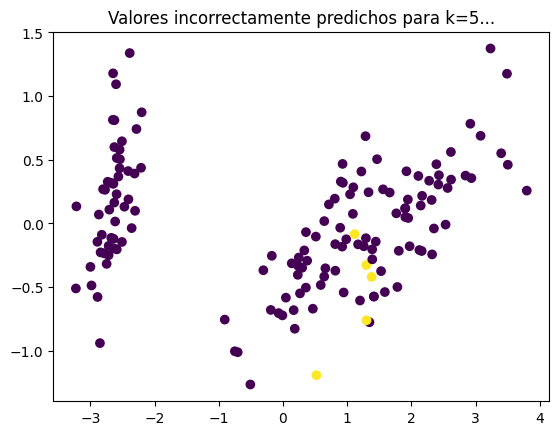

In [6]:
from sklearn.decomposition import PCA


def exploration_curve(X, y, y_pred, k=5):
    pca = PCA(n_components=2, random_state=42)
    pca_X = pca.fit_transform(X)
    color = np.where(y == y_pred, 0, 1)
    plt.scatter(pca_X["pca0"], pca_X["pca1"], c=color)
    plt.title(f"Valores incorrectamente predichos para k={k}...")


exploration_curve(X, y, y_pred, k=5)

Puntaje k = 7: 0.9733333333333334


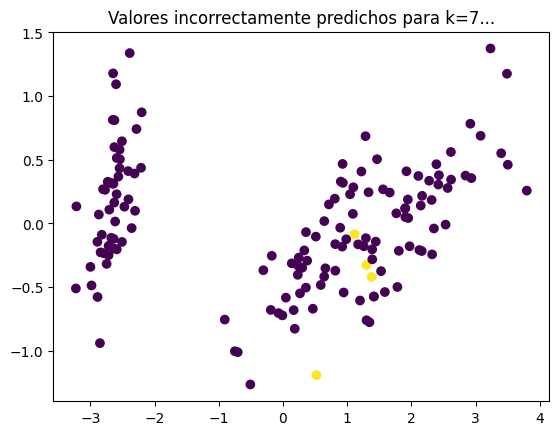

Puntaje k = 9: 0.98


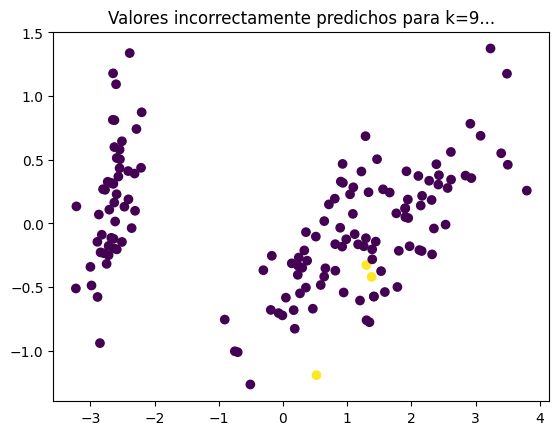

Puntaje k = 11: 0.9733333333333334


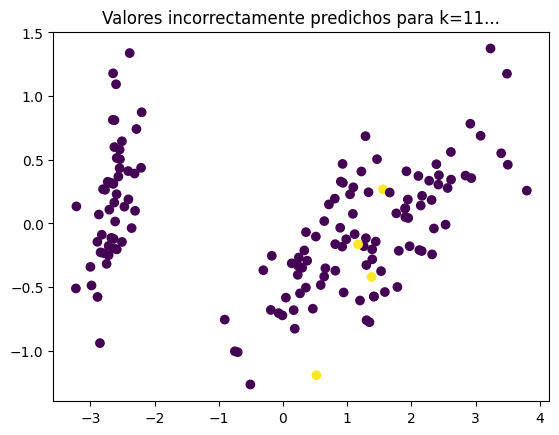

Puntaje k = 13: 0.98


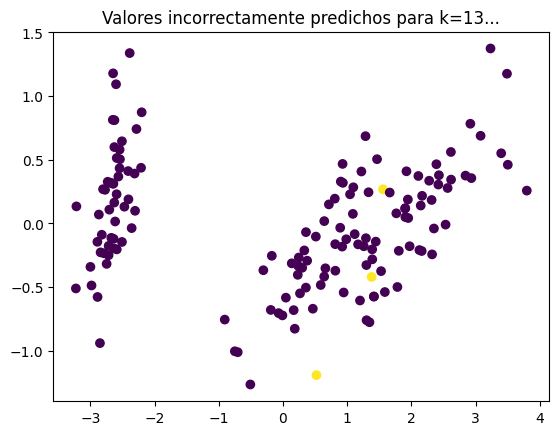

Puntaje k = 15: 0.9866666666666667


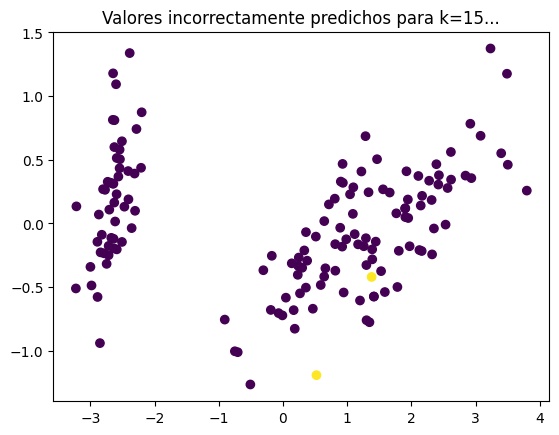

Puntaje k = 17: 0.98


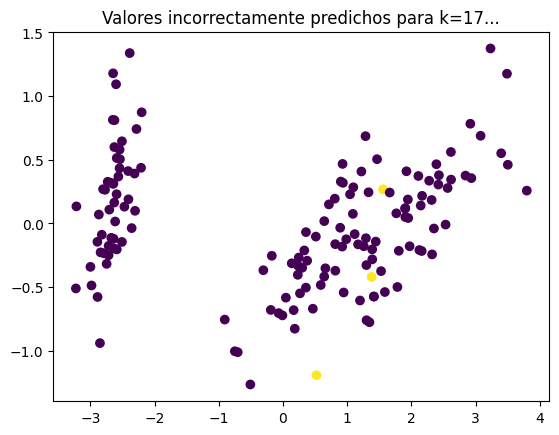

Puntaje k = 19: 0.98


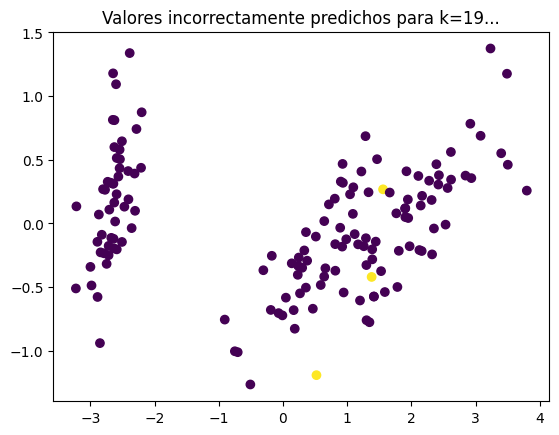

Puntaje k = 21: 0.98


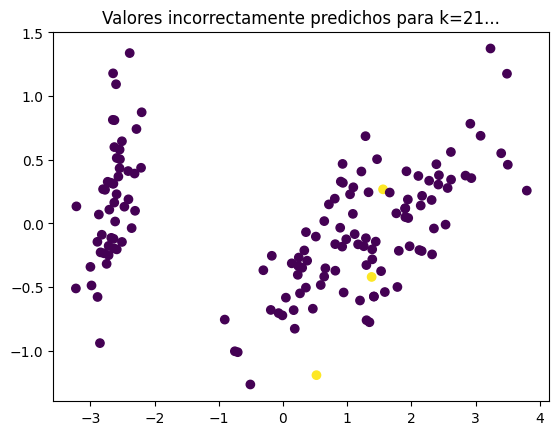

In [7]:
K = [7, 9, 11, 13, 15, 17, 19, 21]
for k in K:
    y_pred = knn_clf(X, y, k=k)
    exploration_curve(X, y, y_pred, k=k)
    plt.show()

Puntaje k = 7: 0.9666666666666667


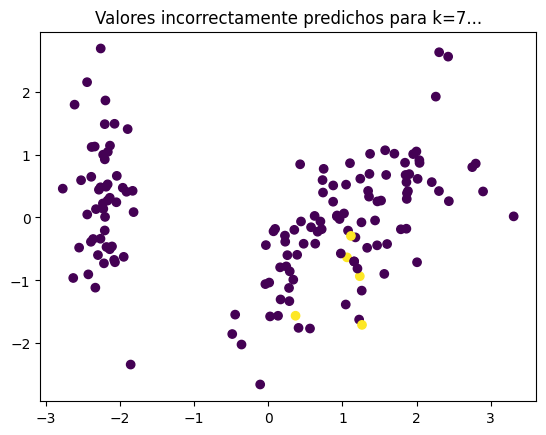

Puntaje k = 9: 0.96


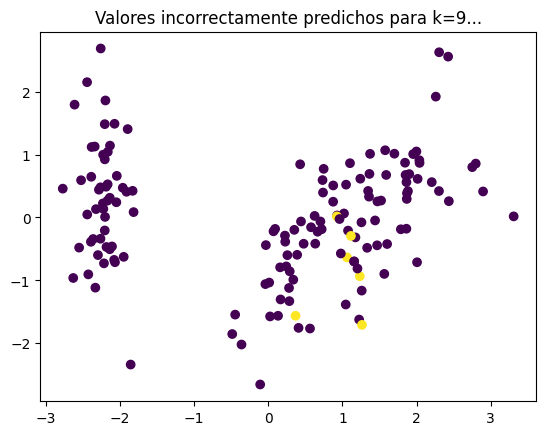

Puntaje k = 11: 0.96


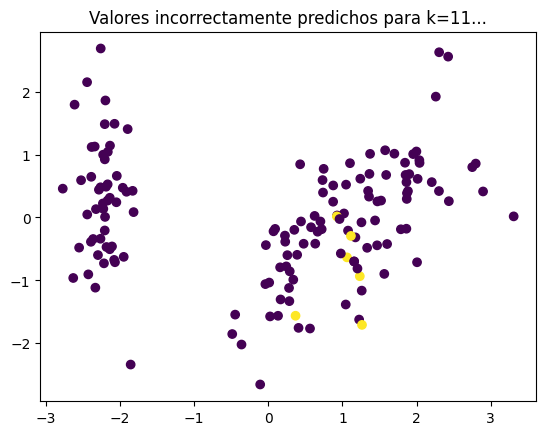

Puntaje k = 13: 0.9666666666666667


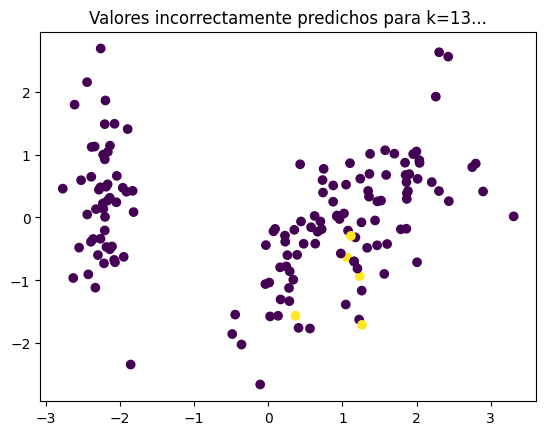

Puntaje k = 15: 0.9666666666666667


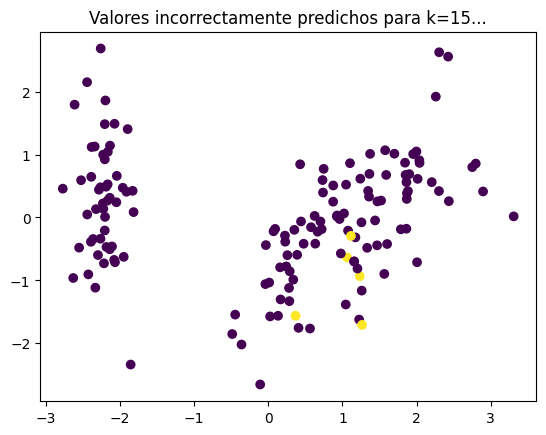

Puntaje k = 17: 0.9733333333333334


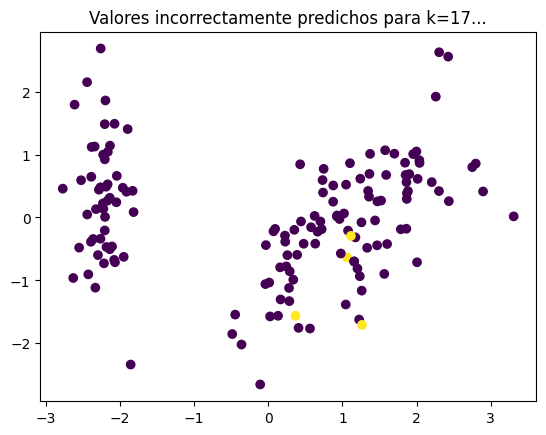

Puntaje k = 19: 0.9666666666666667


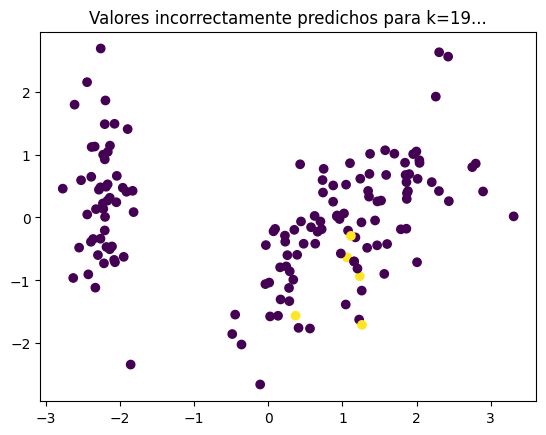

Puntaje k = 21: 0.96


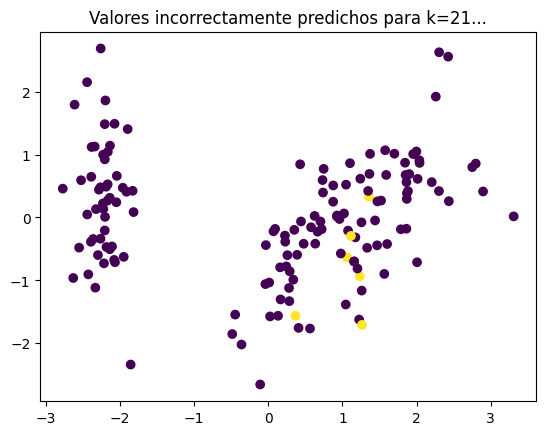

In [8]:
for k in K:
    y_pred_sc = knn_clf(X_sc, y, k=k)
    exploration_curve(X_sc, y, y_pred_sc, k=k)
    plt.show()

> Conclusión: Los Preprocesamientos afectan de manera importante el entrenamiento de un modelo. 

TO BE CONTINUED!!!!

## Regresión

In [9]:
from sklearn.datasets import load_diabetes

data = load_diabetes(as_frame=True)
X = data["data"]
y = data["target"]
X.shape, y.shape

((442, 10), (442,))

Puntaje k = 21: 0.5059363513870989


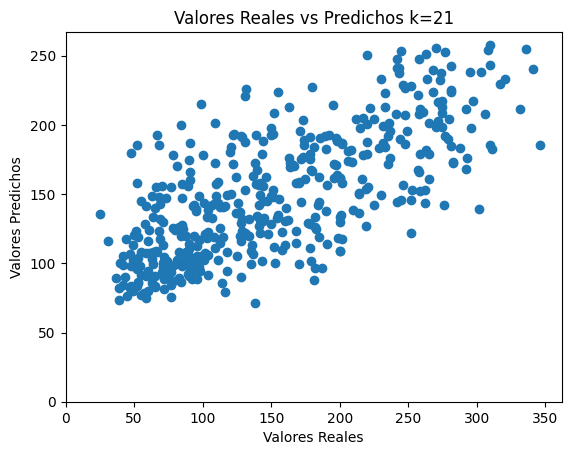

Puntaje k = 19: 0.5143011832339077


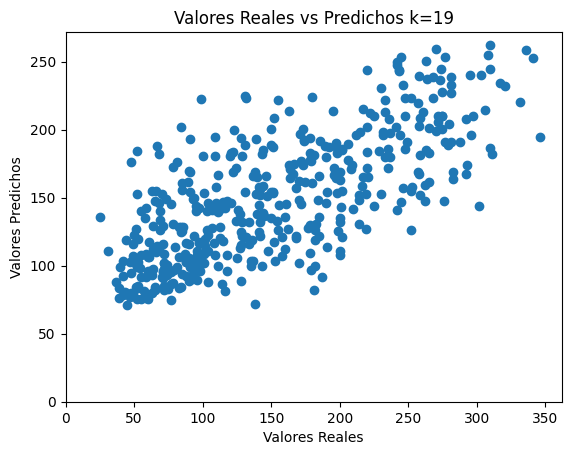

Puntaje k = 17: 0.5119596444787137


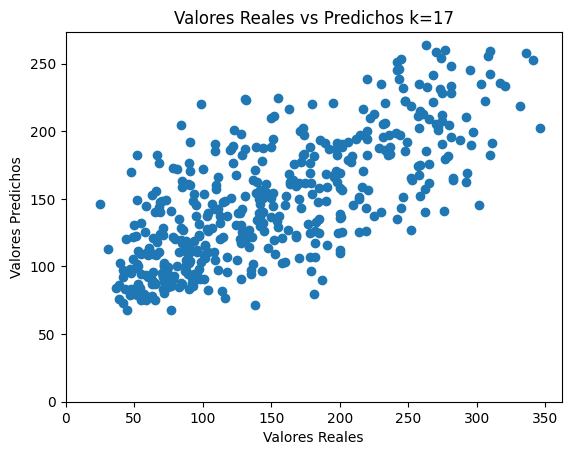

Puntaje k = 15: 0.51750743237297


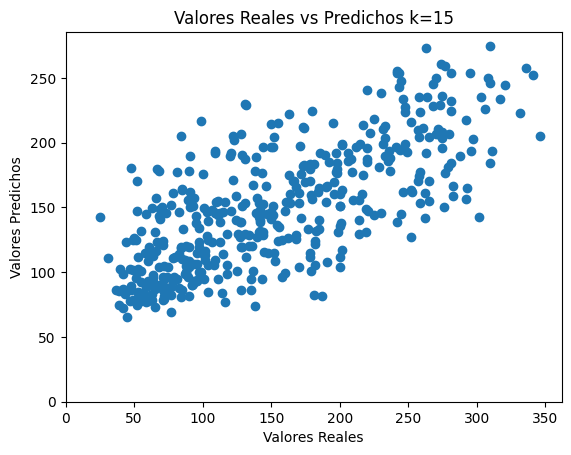

Puntaje k = 13: 0.5215271054213378


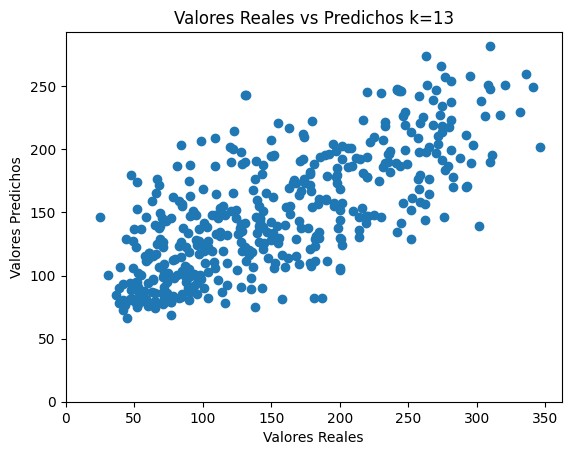

Puntaje k = 11: 0.5315987562045477


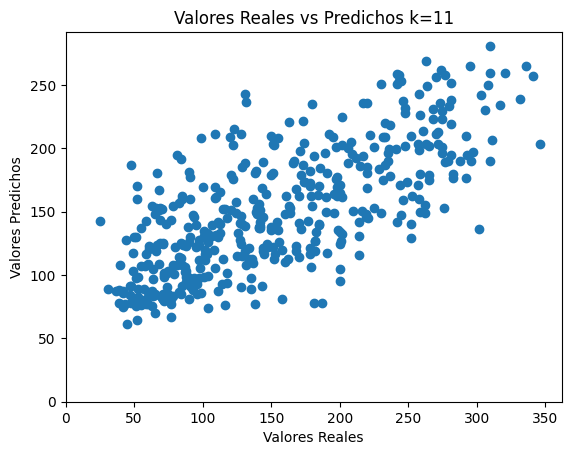

Puntaje k = 9: 0.5432922338717379


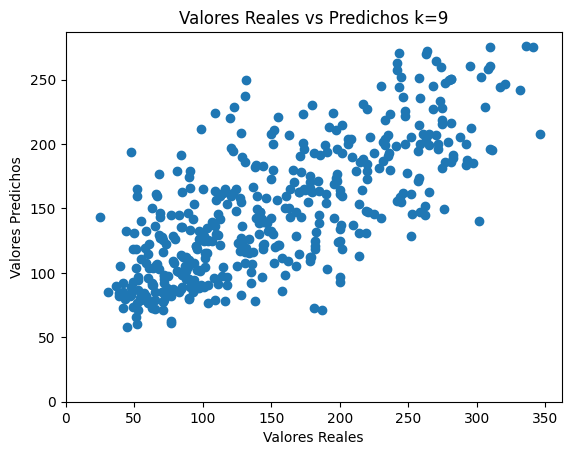

Puntaje k = 7: 0.5587644790133343


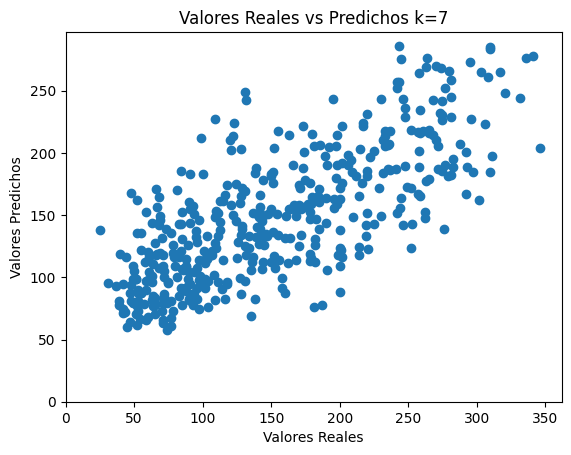

Puntaje k = 5: 0.604957605699507


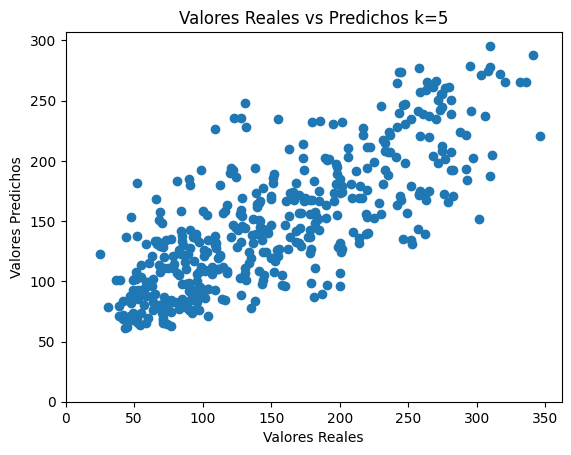

Puntaje k = 3: 0.6704352055547542


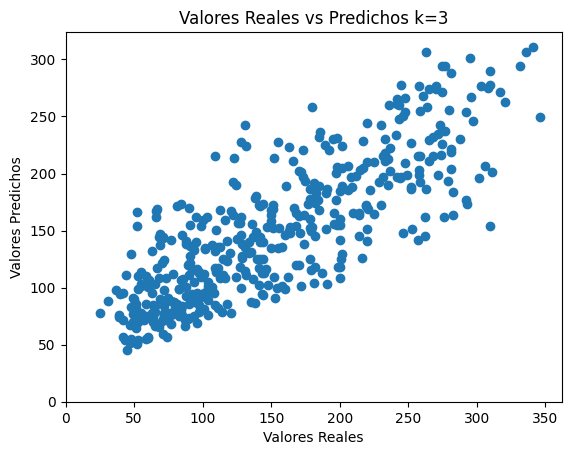

Puntaje k = 1: 1.0


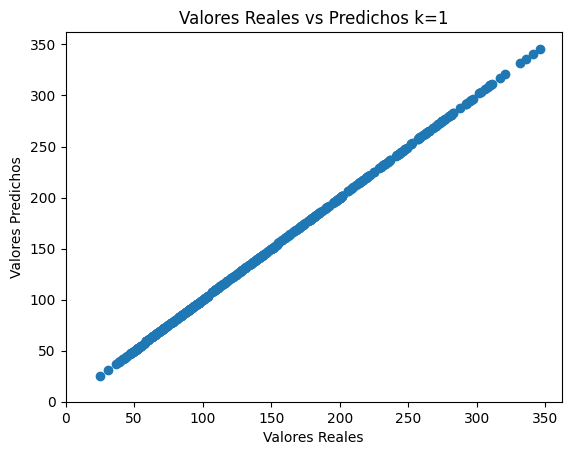

In [16]:
from sklearn.neighbors import KNeighborsRegressor


def knn_reg(X, y, k=5):
    knn_reg = KNeighborsRegressor(n_neighbors=k)
    knn_reg.fit(X, y)
    y_pred = knn_reg.predict(X)
    print(f"Puntaje k = {k}: {knn_reg.score(X,y)}")
    return y_pred


def exploration_curve_reg(X, y, k=k):
    plt.scatter(y, y_pred)
    plt.title(f"Valores Reales vs Predichos k={k}")
    plt.xlim([0, None])
    plt.ylim([0, None])
    plt.xlabel("Valores Reales")
    plt.ylabel("Valores Predichos")


K = [21, 19, 17, 15, 13, 11, 9, 7, 5, 3, 1]
for k in K:
    y_pred = knn_reg(X, y, k=k)
    exploration_curve_reg(X, y, k=k)
    plt.show()